In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import *
import pandas as pd
from openpyxl import Workbook, load_workbook
import scipy.signal as signal
from scipy.optimize import curve_fit

# Path of the Excel File from which Data is Extracted

In [46]:
path=r'C:\Users\kaamil.kaleem\OneDrive - Vibracoustic\Desktop\Curve_fit_test.xlsx'

# Loading of the Workbook

In [47]:
wb = load_workbook(path)
ws_all = wb.sheetnames
print(ws_all)
print(len(ws_all))

['sheet0', 'Sheet1']
2


# Defining the Gaussian Function

In [48]:
def gaussian(x, a, x0, sigma):
    return 2.3 + a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Function to fit the Gaussian Curve

In [49]:
def gaussian_curve_fitting(xdata,ydata):
     # Set initial guesses for the parameters
    a_guess = ydata.max()
    x0_guess = xdata.mean()
    sigma_guess = xdata.std()

    # Use curve_fit to fit the Gaussian function to the data with initial guesses
    popt, pcov = curve_fit(gaussian, xdata, ydata, p0=[a_guess, x0_guess, sigma_guess])
    
    # Extract the fitted parameters
    a_fit, x0_fit, sigma_fit = popt
    
    # Generate a curve using the fitted parameters
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = gaussian(x_fit, a_fit, x0_fit, sigma_fit)
    
    return x_fit, y_fit

# Function to find the peak width

In [50]:
def peak_width(x,y,Max_peak):
    xnew = np.linspace(min(x),max(x),10000)
    f = interpolate.interp1d(x, y)
    ynew = f(xnew)
    target = Max_peak*0.5
    #print(target)
    b=0
    a=0
    ay=0
    by=0
    for i in range(len(xnew)):
        if ynew[i]-target>0:
            a=xnew[i]
            j=i
            ay=ynew[i]
            break
    for i in range(j,len(xnew)):
        if ynew[i]-target<0:
            b=xnew[i]
            by=ynew[i]
            break
    return a,ay,b,by,b-a

# Importing data and exporting peak parameters(the most important)

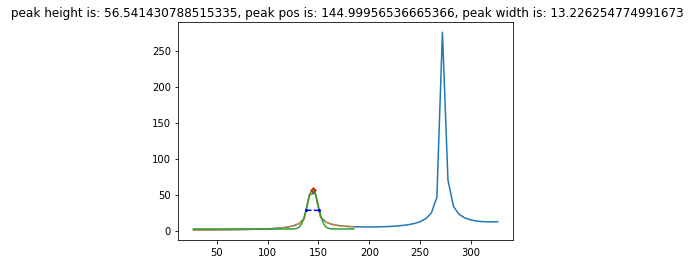

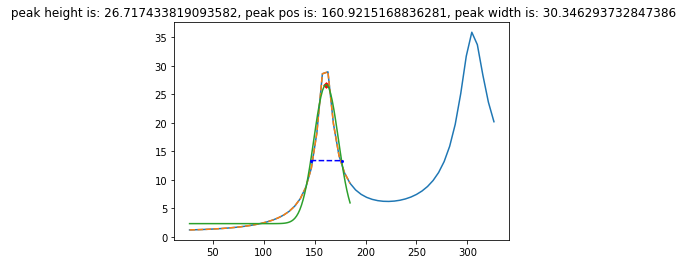

In [51]:
for i in range(len(ws_all)):
    nor=pd.read_excel(path, sheet_name=i)
    x_fre = nor['Norm Frq']
    y_dyn= nor['Norm Dyn']
    x=np.array(x_fre)
    y=np.array(y_dyn)
    
    #Finding the Peaks
    peaks,_=signal.find_peaks(y) # this returns the index of the peaks
    peak_height = y[peaks[0]]
    peak_pos = x[peaks[0]]
    #fig = plt.figure()
    #ax=fig.subplots()
    #ax.scatter(peak_pos, peak_height, color='r', s=15, marker='x', label='Peak')
    #ax.plot(x, y)
    
    #Extracting only the first curve
    if peaks.size>0:
        max_peak_index=peaks[0]
        baseline =np.mean(y[:max_peak_index])
        for j in range(max_peak_index, len(y)):
            if y[j]<=baseline:
                end_index=j
                break
        x_end = x[:end_index]
        y_end = y[:end_index]
    #ax.plot(x_end,y_end,'--')
    
    #Fitting the gaussian curve for the first peak
    x_fit, y_fit =gaussian_curve_fitting(x_end,y_end)
    #ax.plot(x_fit, y_fit)
    
    #finding peaks for the gcurve
    new_peaks,_=signal.find_peaks(y_fit)
    new_peak_height = y_fit[new_peaks[0]]
    new_peak_pos = x_fit[new_peaks[0]]
    #ax.scatter(new_peak_pos, new_peak_height, color='r', s=15, marker='D', label='Peak')
    
    #Finding the peak Width
    width=peak_width(x_fit,y_fit,new_peak_height)
    pwx=[width[0], width[2]]
    pwy=[width[1], width[3]]
    #ax.plot(pwx,pwy,'bo', markersize=2,ls='--')
    width_peak=width[4]
    
    
    #Plotting the complete Curve
    fig = plt.figure()
    ax=fig.subplots()
    plt.title(f" peak height is: {new_peak_height}, peak pos is: {new_peak_pos}, peak width is: {width_peak}")
    ax.plot(x, y)
    ax.plot(x_end,y_end,'--')
    ax.plot(x_fit, y_fit)
    ax.scatter(new_peak_pos, new_peak_height, color='r', s=15, marker='D', label='Peak')
    ax.plot(pwx,pwy,'bo', markersize=2,ls='--')
    

    
    #Exporting the values back to Excel
    ws = ws_all[i]
    k = wb[ws]
    k['J1']=new_peak_height
    k['J2']=new_peak_pos
    k['J3']=width_peak
    

    
#Saving the file
wb.save(path)



# Writing Output to file

In [52]:
path_2=r'C:\Users\kaamil.kaleem\OneDrive - Vibracoustic\Desktop\Curve_fit_test.txt'
wb = load_workbook(path)
wb_all=wb.sheetnames
f = open(path_2,'a')
f.write(f"a,b,c,max_peak,width_peak,fre_peak\n")
for i in range(len(wb_all)):
    ws=wb_all[i]
    k=wb[ws]
    a=k['B2'].value
    b=k['B3'].value
    c=k['B4'].value
    max_peak=k['J1'].value
    width_peak=k['J2'].value
    fre_peak=k['J3'].value
    f.write(f"{a},{b},{c},{max_peak},{width_peak},{fre_peak}\n")
f.close()
wb.save(path)